# PYKU 데이터 전처리 기초

이 절에서는 데이터를 본격적으로 분석하기 이전에 다음과 같은 패키지를 사용하여 기초적인 전처리(preprocessing)를 하는 방법을 설명한다. 

* missingno 패키지: 결측 데이터 검색
* sklearn.impute 패키지: 결측 데이터 대체
* patsy 패키지: 데이터 선택, 변환, 추가, 스케일링
* sklearn.preprocessing 패키지: 스케일링, 변환

In [1]:
# 시각화 기본 설정
%matplotlib inline

# Load visualization pakage
import matplotlib as mpl
import matplotlib.pyplot as plt

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

### missingno 패키지

현실에서 데이터를 수집하다보면 데이터의 일부를 얻지 못하거나 누락되는 결측(missing) 데이터가 생긴다. missingno 패키지는 pandas 데이터프레임에서 결측 데이터를 찾는 기능을 제공한다. 이 패키지를 사용하려면 데이터프레임에 결측 데이터가 `NaN`(not a number) 값으로 저장되어 있어야 한다. 

주의할 점은 `NaN`값은 부동소수점 실수 자료형에만 있는 값이므로 정수 자료를 데이터프레임에 넣을 때는 `Int64Dtype` 자료형을 명시해주어야 하고 시간 자료형을 넣을 때도 `parse_dates` 인수로 날짜시간형 파싱을 해주어야 `datetime64[ns]` 자료형이 되어 결측 데이터가 `NaT`(not a time) 값으로 표시된다.

In [2]:
from io import StringIO
import pandas as pd


csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")

df = pd.read_csv(csv_data, dtype={"x1": pd.Int64Dtype()}, parse_dates=[3])
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,NaN,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,NaN,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


판다스 데이터프레임 자체도 `isnull()` 또는 `isna()` 메서드로 사용하면 결측 데이터의 위치를 알아내는 것이 가능하다. 

In [3]:
df.isnull()

,x1,x2,x3,x4,x5
0,False,False,False,False,False
1,False,True,True,False,False
2,False,True,False,False,False
3,True,False,False,False,False
4,False,False,False,False,False
5,True,True,True,False,False
6,False,False,False,True,False
7,False,False,False,False,False
8,False,False,True,False,False


하지만 데이터가 많은 경우에는 일일히 확인할 수 없으므로 기껏해야 `sum()` 메서드를 결합하여 결측 데이터의 갯수를 유추하는 것만 가능하다.

In [4]:
df.isnull().sum()

x1    2
x2    3
x3    3
x4    1
x5    0
dtype: int64

하지만 missingno 패키지를 사용하면 대규모의 데이터에서도 결측 데이터에 대한 시각화를 쉽게 할 수 있다. `matrix()` 함수는 결측 데이터를 시각화하는 명령이다. 결측된 데이터는 흰색으로, 그렇지 않은 데이터는 검은색으로 나타난다. 가장 오른쪽에 있는 것은 스파크라인(spark line)이라고 부르고, 각 행의 데이터 완성도를 표현한다.

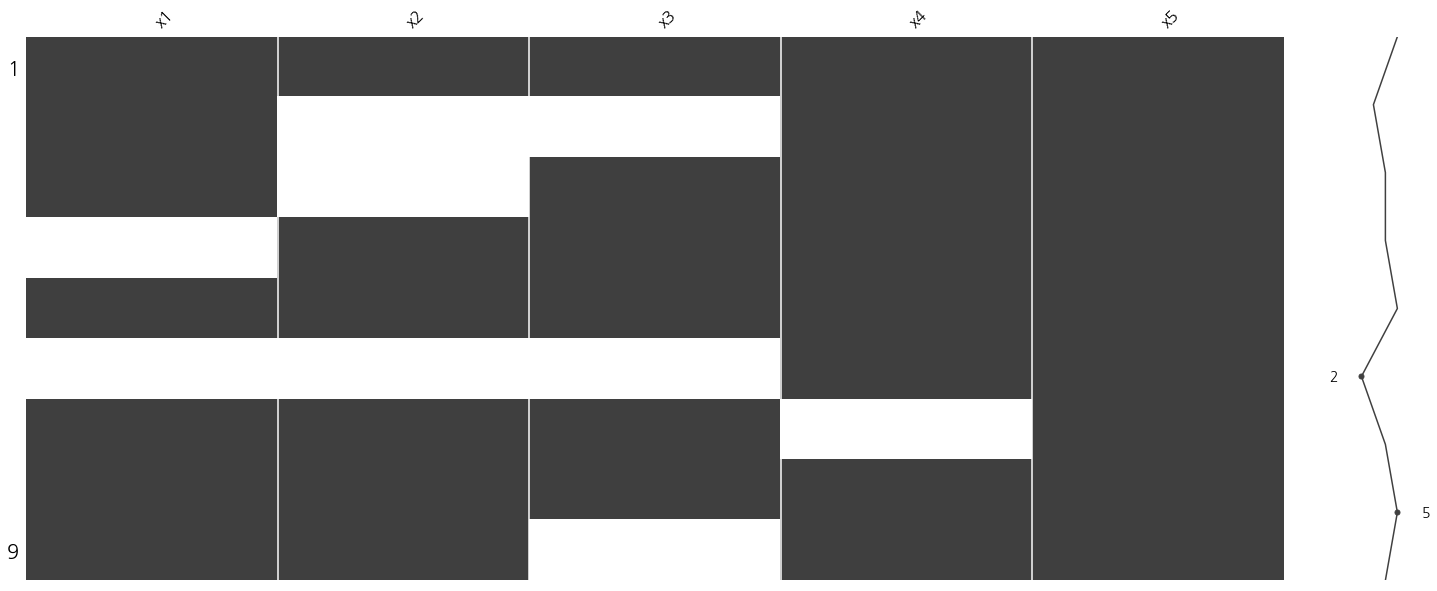

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()

만약 각 열에 결측 데이터가 얼마나 존재하는지 시각화 하고 싶다면, `bar()` 함수를 사용한다.

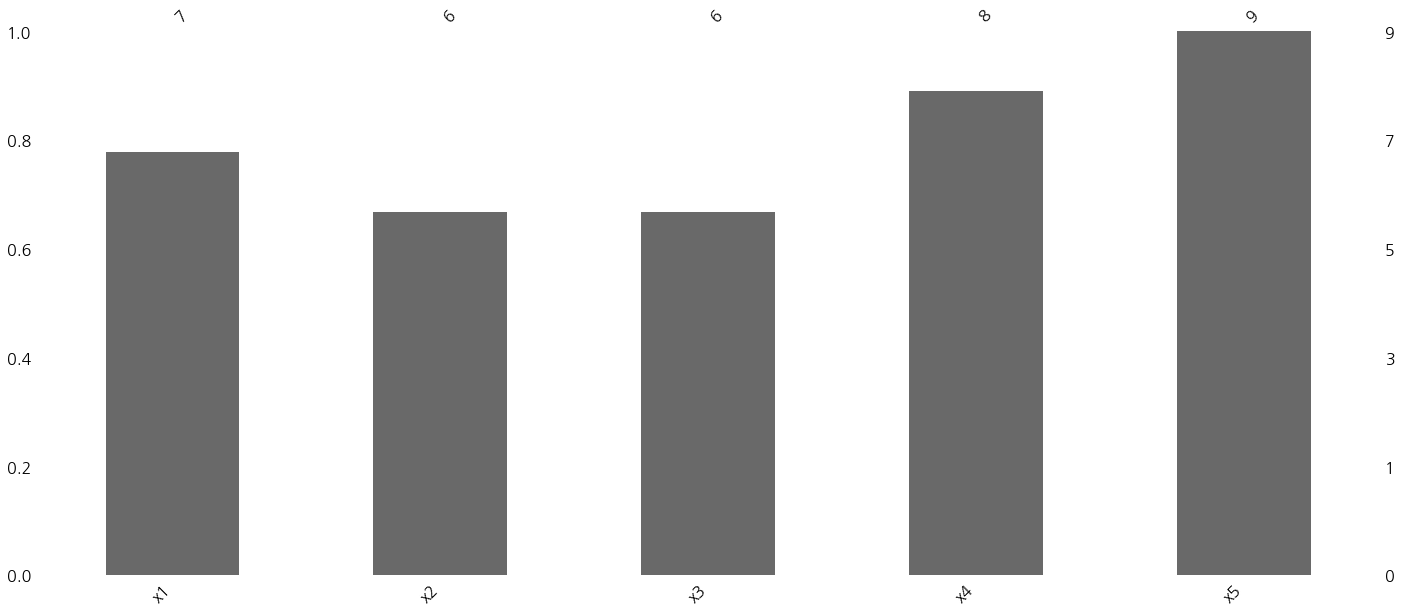

In [6]:
msno.bar(df)
plt.show()

대규모 데이터에서 missingno 패키지가 어떻게 쓰일 수 있는지 살펴보기 위해 타이나닉 생존자 데이터를 예로 들어본다. 타이타닉 생존자 데이터는 seaborn 패키지에서 제공하는 예제 데이터다. 

In [7]:
import seaborn as sns
titanic = sns.load_dataset("titanic")
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


각 열이 의미하는 바는 다음과 같다.

* survived : 생존 여부
* pclass : 승객의 클래스
* sex : 성별. male, female로 표기
* sibsp : 형제 혹은 자매의 수
* parch : 부모 혹은 자녀의 수
* fare : 탑승 요금
* embarked : 출발지의 고유 이니셜
* class : 선실의 클래스
* who : male, female을 man, woman으로 표기
* adult_male : 성인 남성 인지 아닌지 여부
* deck : 선실 고유 번호의 가장 앞자리 알파벳(A ~ G)
* embark_town : 출발지
* alive : 생존 여부 데이터를 yes 혹은 no로 표기
* alone : 가족이 없는 경우 True

missingno를 이용하여 타이타닉 데이터를 살펴보면 age, deck, embarkd, embark_town 열 등에 결측 데이터가 있는 것을 볼 수 있다.

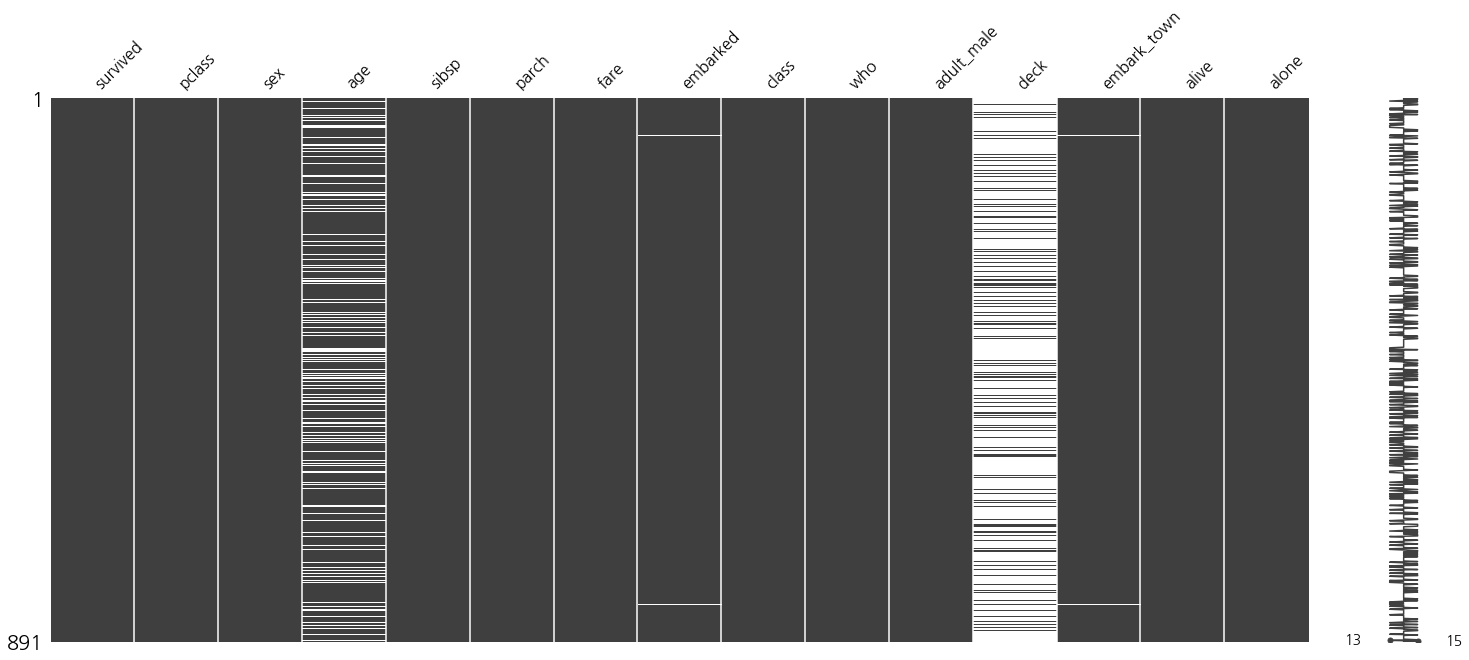

In [8]:
msno.matrix(titanic)
plt.show()

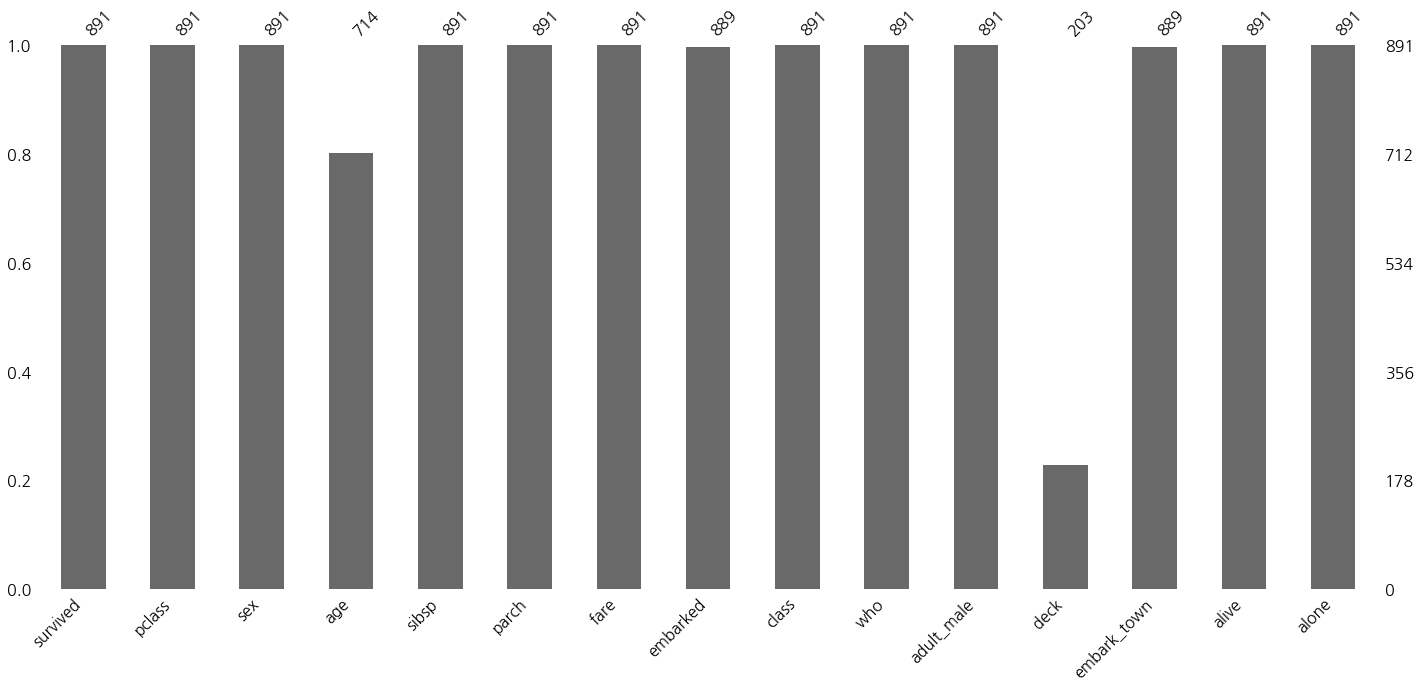

In [9]:
msno.bar(titanic)
plt.show()

결측된 데이터를 처리하는 방법은 두 가지다.

* 결측된 데이터가 너무 많은 경우 해당 데이터 열 전체를 삭제할 수 있다.
* 결측된 데이터가 일부인 경우 가장 그럴듯한 값으로 대체할 수 있다. 이를 **결측 데이터 대체(imputation)**라고 한다.

판다스의 `dropna()` 메서드를 사용하면 결측 데이터가 존재하는 행이나 열을 지울 수 있다. 다음 코드는 위에서 예로 든 df 데이터프레임에서 결측 데이터가 존재하는 모든 행을 지운다.

In [10]:
df.dropna()

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
4,5,0.5,5.0,2019-01-05,B
7,8,0.8,8.0,2019-01-08,B


`axis` 인수를 1로 설정하면 결측 데이터가 있는 열을 제거한다.

In [11]:
df.dropna(axis=1)

,x5
0,A
1,B
2,C
3,A
4,B
5,C
6,A
7,B
8,C


`thresh` 인수를 사용하면 특정 갯수 이상의 비결측 데이터가 있는 행 또는 열만 남긴다.

In [12]:
df.dropna(thresh=7, axis=1)

,x1,x4,x5
0,1,2019-01-01,A
1,2,2019-01-02,B
2,3,2019-01-03,C
3,NaN,2019-01-04,A
4,5,2019-01-05,B
5,NaN,2019-01-06,C
6,7,NaT,A
7,8,2019-01-08,B
8,9,2019-01-09,C


타이타닉 데이터에서 deck 데이터는 결측된 데이터가 너무 많기 때문에 이 방법으로 데이터를 삭제한다.

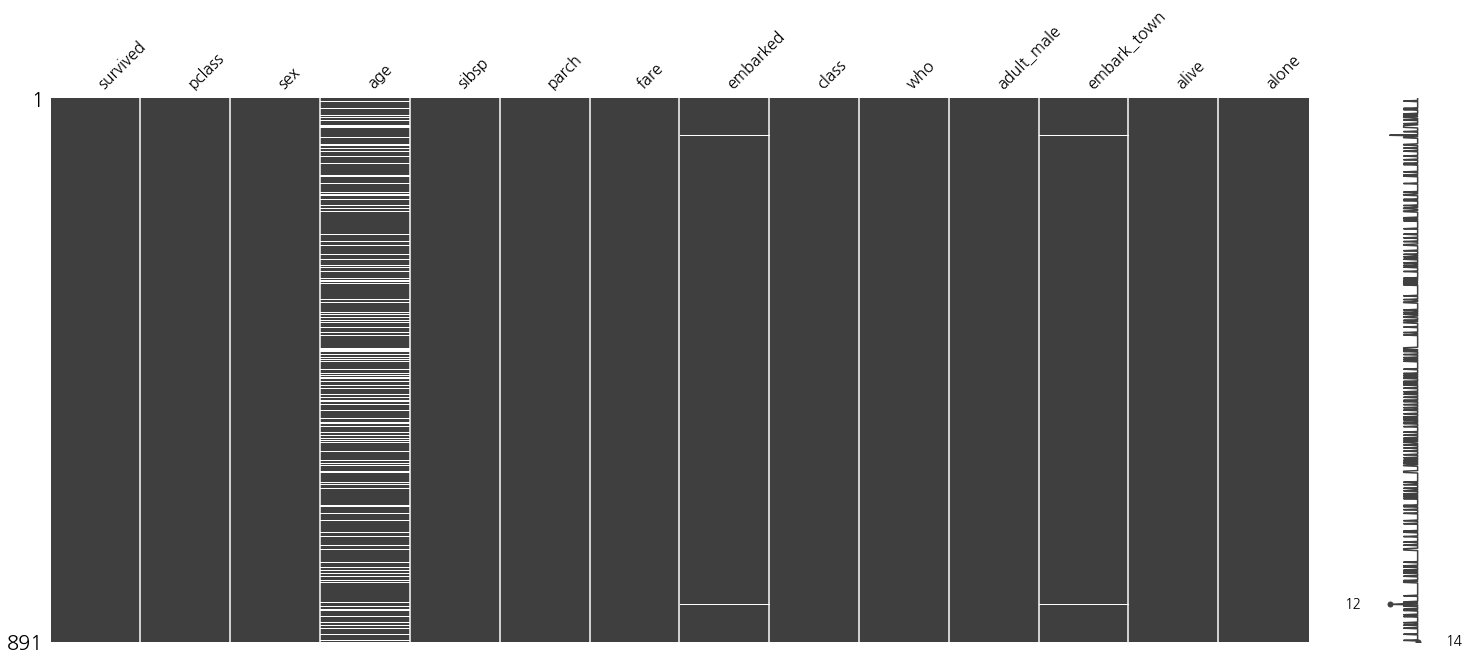

In [13]:
# 데이터가 절반 이상이 없는 열을 삭제
titanic = titanic.dropna(thresh=int(len(titanic) * 0.5), axis=1)
msno.matrix(titanic)
plt.show()

결측 데이터를 대체할 때는 해당 열의 비결측 데이터의 평균값 혹은 중앙값 등을 대체값으로 사용하여 결측된 데이터를 채운다. scikit-learn 패키지의 `SimpleImputer` 클래스를 사용하면 쉽게 결측 데이터를 대체할 수 있다. 사용법은 다음과 같다.

1. `SimpleImputer` 클래스 객체를 생성한다. 이 대 `strategy` 인수를 `"mean"`으로 하면 중앙값 `"median"`으로 하면 중앙값, `"most_frequent"`로 하면 최빈값을 대체값으로 사용한다.
2. `fit_transform` 메서드를 사용하여 대체값이 채워신 데이터프레임을 생성한다. 

`strategy` 인수를 선택하는 방법은 다음과 같다.

1. 데이터가 실수 연속값인 경우에는 평균 또는 중앙값을 사용할 수 있다. 값의 분포가 대칭적이면 평균이 좋고 값의 분포가 심하게 비대칭인 경우에는 중앙값이 적당하다.
2. 데이터가 범주값이거나 정수값인 경우에는 최빈값을 사용할 수 있다.


In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,x1,x2,x3,x4,x5
0,1,0.1,1,2019-01-01 00:00:00,A
1,2,0.1,1,2019-01-02 00:00:00,B
2,3,0.1,3,2019-01-03 00:00:00,C
3,1,0.4,4,2019-01-04 00:00:00,A
4,5,0.5,5,2019-01-05 00:00:00,B
5,1,0.1,1,2019-01-06 00:00:00,C
6,7,0.7,7,2019-01-01 00:00:00,A
7,8,0.8,8,2019-01-08 00:00:00,B
8,9,0.9,1,2019-01-09 00:00:00,C


이번에는 타이타닉 데이터에서 embark_town 데이터부터 대체해보자. 이 값은 범주값이므로 `strategy="most_frequent"`로 하여 최빈값을 대체값으로 사용한다. 대체하기 전의 embark_town 데이터 분포를 살펴보면 Southhamton 값이 가장 많다. 대체 후에는 이 값으로 결측 데이터가 대체될 것이다.

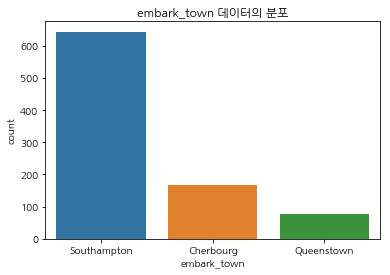

In [15]:
sns.countplot(titanic.embark_town)
plt.title("embark_town 데이터의 분포")
plt.show()

In [16]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


`SimpleImputer` 클래스로 대체를 한 결과는 다음과 같다. `embarked` 데이터도 사실상 같은 데이터이므로 같이 대체한다.

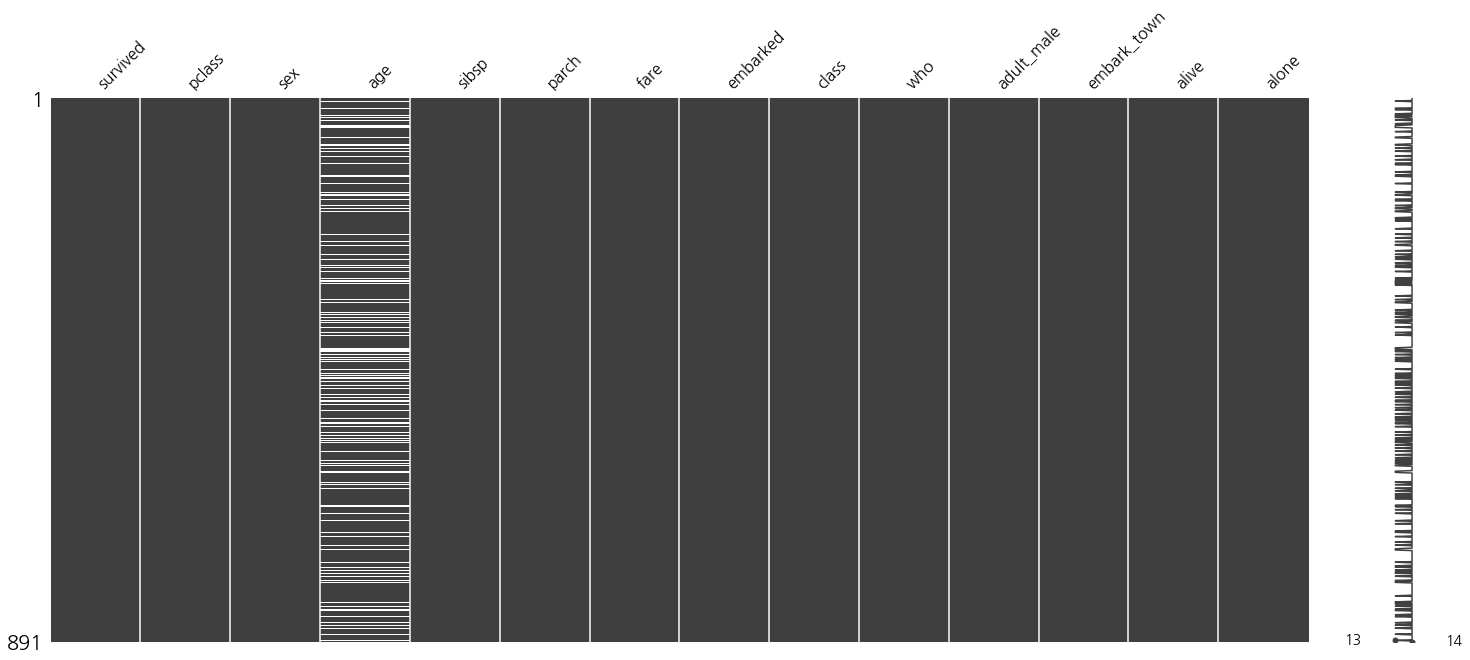

In [17]:
from sklearn.impute import SimpleImputer

imputer_embark_town = SimpleImputer(strategy="most_frequent")
titanic["embark_town"] = imputer_embark_town.fit_transform(titanic[["embark_town"]])
titanic["embarked"] = imputer_embark_town.fit_transform(titanic[["embarked"]])

msno.matrix(titanic)
plt.show()

다음으로 age 데이터를 대체한다. 대체하기 전의 age 데이터 분포를 살펴보면 비대칭인 것을 볼 수 있다.

C:\Users\sesal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\sesal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\sesal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


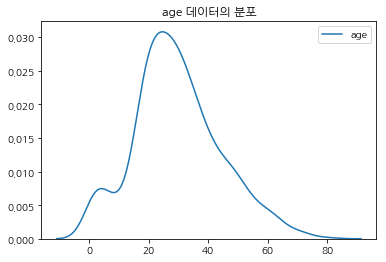

In [18]:
sns.kdeplot(titanic.age)
plt.title("age 데이터의 분포")
plt.show()

따라서 `strategy="median"`로 하여 중앙값을 대체값으로 사용한다. 다음 그림에서 결측값이 사라진 것을 확인할 수 있다. 

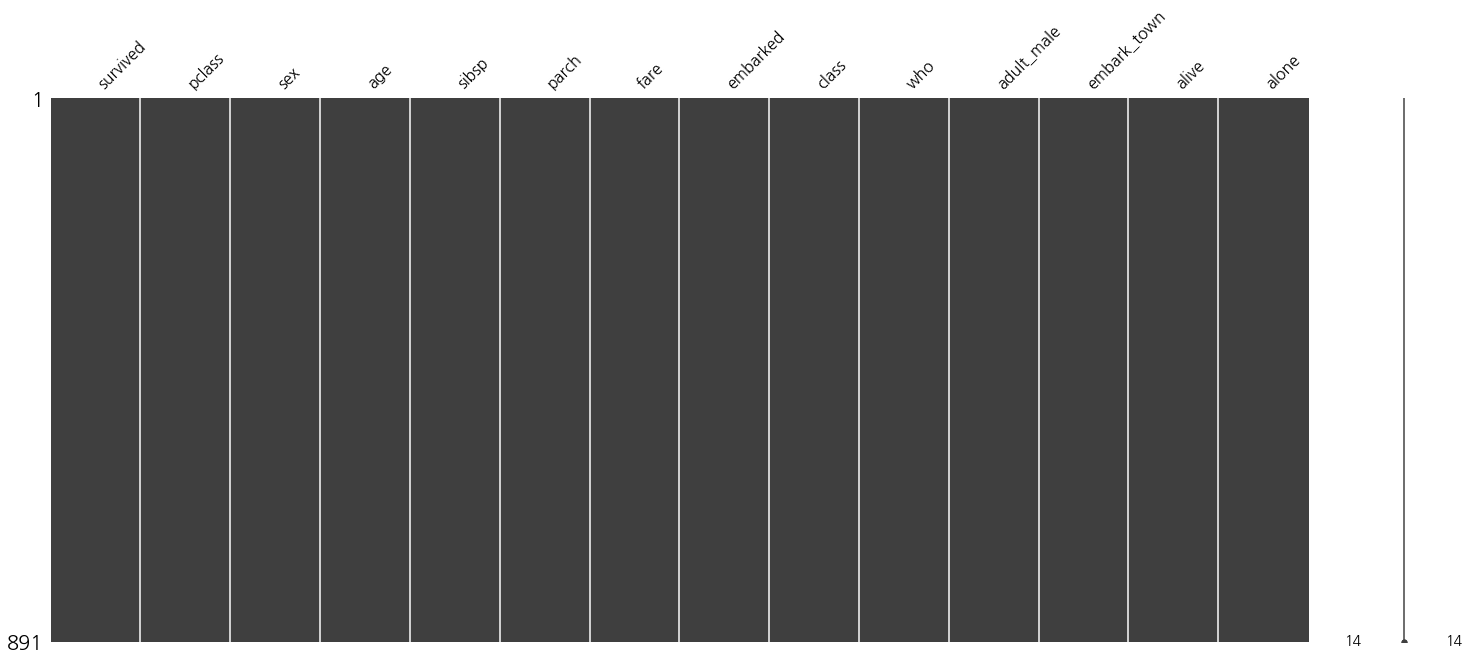

In [19]:
imputer_age = SimpleImputer(strategy="median")
titanic["age"] = imputer_age.fit_transform(titanic[["age"]])

msno.matrix(titanic)
plt.show()

### patsy 패키지

이번에는 patsy 패키지를 사용하여 데이터프레임에서 원하는 데이터만 선택하거나 새로운 데이터를 조합 생성하는 방법을 살펴본다. 설명을 위해 patsy 패키지가 제공하는 `demo_data()` 함수로 다음과 같은 예제 데이터프레임을 만들자. `demo_data()` 함수는 `x`로 시작하는 변수에 대해 임의의 실수 데이터를 생성한다.

In [20]:
from patsy import demo_data

df = pd.DataFrame(demo_data("x1", "x2", "x3", "x4", "x5"))
df

,x1,x2,x3,x4,x5
0,1.764052,-0.977278,0.144044,0.333674,-2.552990
1,0.400157,0.950088,1.454274,1.494079,0.653619
2,0.978738,-0.151357,0.761038,-0.205158,0.864436
3,2.240893,-0.103219,0.121675,0.313068,-0.742165
4,1.867558,0.410599,0.443863,-0.854096,2.269755


데이터 분석을 시작할 때는 다양한 데이터를 하나의 데이터프레임에 넣고 시작하는 경우가 많다.  patsy 패키지가 제공하는 `dmatrx()` 함수를 사용하면 데이터 프레임에 상수항을 추가하거나 원하는 데이터만 선택하거나 변형할 수 있다. `dmatrx()` 함수에 모형 정의 문자열 `formula`와 원 데이터를 담은 데이터프레임 data을 입력하면 `formula`에서 지정한 대로 변환된 데이터 data_transformed를 출력한다.

```
data_transformed = dmatrix(formula, data)
```

formula는 데이터 열 이름 기반으로 구성된 문자열이다. 선택하고자 하는 데이터 열 이름을 `+`로 연결한 formula 문자열을 입려하면 자동으로 해당 데이터만 뽑아준다. 예를 들어 전체 데이터 중 x1만을 뽑고 싶으면 formula 문자열에 `x1 + 0`이라고 입력한다.

In [21]:
from patsy import dmatrix 

dmatrix("x1 + 0", data=df)

DesignMatrix with shape (5, 1)
       x1
  1.76405
  0.40016
  0.97874
  2.24089
  1.86756
  Terms:
    'x1' (column 0)

전체 데이터 중 x1, x2, x3를 뽑고 싶으면 formula 문자열에 `x1 + x2 + x3 + 0`이라고 입력한다.

In [22]:
dmatrix("x1 + x2 + x3 + 0", data=df)

DesignMatrix with shape (5, 3)
       x1        x2       x3
  1.76405  -0.97728  0.14404
  0.40016   0.95009  1.45427
  0.97874  -0.15136  0.76104
  2.24089  -0.10322  0.12168
  1.86756   0.41060  0.44386
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x3' (column 2)

`+ 0`은 1로 구성된 상수항을 넣지 말라는 뜻이다. 만약 이 부분이 없으면 patsy는 자동으로 가장 앞에 Intercept란 이름의 상수항 데이터를 추가한다. 

In [23]:
dmatrix("x1 + x2 + x3", data=df)

DesignMatrix with shape (5, 4)
  Intercept       x1        x2       x3
          1  1.76405  -0.97728  0.14404
          1  0.40016   0.95009  1.45427
          1  0.97874  -0.15136  0.76104
          1  2.24089  -0.10322  0.12168
          1  1.86756   0.41060  0.44386
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x3' (column 3)

`- 1`도 `+ 0`과 같은 뜻이다.

In [24]:
dmatrix("x1 + x2 + x3 - 1", data=df)

DesignMatrix with shape (5, 3)
       x1        x2       x3
  1.76405  -0.97728  0.14404
  0.40016   0.95009  1.45427
  0.97874  -0.15136  0.76104
  2.24089  -0.10322  0.12168
  1.86756   0.41060  0.44386
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x3' (column 2)

`dmatrix()` 함수는 변수를 어떤 함수에 넣어서 다른 갑으로 만드는 수학 변환(transform)도 가능하다. 

In [25]:
import numpy as np
dmatrix("x1 + np.log(np.abs(x2))", df)

DesignMatrix with shape (5, 3)
  Intercept       x1  np.log(np.abs(x2))
          1  1.76405            -0.02298
          1  0.40016            -0.05120
          1  0.97874            -1.88811
          1  2.24089            -2.27090
          1  1.86756            -0.89014
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'np.log(np.abs(x2))' (column 2)

numpy 함수 뿐 아니라 사용자 정의 함수도 사용할 수 있다.

In [26]:
def ten_times(x):
    return 10 * x

dmatrix("ten_times(x1)+0", df)

DesignMatrix with shape (5, 1)
  ten_times(x1)
       17.64052
        4.00157
        9.78738
       22.40893
       18.67558
  Terms:
    'ten_times(x1)' (column 0)

기존의 데이터를 조합 연산하여 새로운 데이터를 만드는 것도 가능하다. 특히 두 변수를 곱해서 만들어지는 새로운 변수를 **상호작용(interaction)**이라고 한다. 상호작용은 `:` 기호를 사용하여 만들어진다. 

In [27]:
dmatrix("x1 + x2 + x1:x2 + 0", df)

DesignMatrix with shape (5, 3)
       x1        x2     x1:x2
  1.76405  -0.97728  -1.72397
  0.40016   0.95009   0.38018
  0.97874  -0.15136  -0.14814
  2.24089  -0.10322  -0.23130
  1.86756   0.41060   0.76682
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x1:x2' (column 2)

두 변수와 상호작용을 한꺼번에 표시할 때는 `*`를 사용한다. 따라서  다음 수식은 바로 전의 수식과 동일하다.

In [28]:
dmatrix("x1 * x2 + 0", df)

DesignMatrix with shape (5, 3)
       x1        x2     x1:x2
  1.76405  -0.97728  -1.72397
  0.40016   0.95009   0.38018
  0.97874  -0.15136  -0.14814
  2.24089  -0.10322  -0.23130
  1.86756   0.41060   0.76682
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x1:x2' (column 2)

상호작용을 제외한  경우에는 `I()`라는 연산자를 사용하여 연산과정을 명시해야 한다. 예를 들어 두 변수 x1과 x2를 더하여 새로운 데이터를 만들고 싶다면 다음과 같이 한다.

In [29]:
dmatrix("x1 + x2 + I(x1 + x2) + 0", df)

DesignMatrix with shape (5, 3)
       x1        x2  I(x1 + x2)
  1.76405  -0.97728     0.78677
  0.40016   0.95009     1.35025
  0.97874  -0.15136     0.82738
  2.24089  -0.10322     2.13767
  1.86756   0.41060     2.27816
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'I(x1 + x2)' (column 2)

선형회귀분석을 할 때는 조건수(condition number)의 영향때문에 데이터의 평균을 0으로 표준편차를 1로 만드는 **스케일링(scaling)** 작업을 하는 것이 분석 결과의 품질을 높일 수 있다. patsy 패키지는 스케일링을 위한 함수도 제공한다.

* `center()`: 평균을 0으로 스케일링
* `standardize()`: 평균을 0으로하고 표준편차를 1로 스케일링
* `scale()`: `standardize()` 과 같음

예를 들어 x1 데이터의 평균을 제거하는 변환은 다음과 같다.

In [30]:
dm = dmatrix("center(x1) + 0", df)
dm

DesignMatrix with shape (5, 1)
  center(x1)
     0.31377
    -1.05012
    -0.47154
     0.79061
     0.41728
  Terms:
    'center(x1)' (column 0)

이 변환 연산은 다음과 같이 x1 데이터에서 x1의 평균을 빼는 것과 같다.

In [31]:
df.x1 - np.mean(df.x1)

0    0.313773
1   -1.050123
2   -0.471542
3    0.790613
4    0.417278
Name: x1, dtype: float64

이 때 평균값은 `design_info`라는 속성 내부에 저장된다.

In [32]:
dm.design_info.factor_infos

{EvalFactor('center(x1)'): FactorInfo(factor=EvalFactor('center(x1)'),
            type='numerical',
            state=<factor state>,
            num_columns=1)}

이 값을 저장하는 이유는 다음과 같. 어떤 학습용 데이터를 사용하여 예측모형을 만든다고 하자. 이 때 학습성능을 좋게 하기 위해 학습용 데이터의 평균값을 데이터에서 빼는 스케일링을 실시하였다. 학습이 끝난 후 이 모형을 사용하여 실제 예측을 할 때 새로운 검증용 데이터를 이 모형에 넣으려면 모형을 학습할 때 사용한 것과 동일한 전처리를 해야 한다. 이 때 학습용 데이터의 평균값을 빼야 한다는 점에 주의한다. 이렇게 하기 위해서는 전처리 과정에서 계산한 평균값을 기억하고 있어야 한다.

### sklearn.preprocessing 패키지

sklearn패키지의 preprocessing 서브패키지도 스케일링 및 변수변환을 위한 `StandardScaler` 클래스는 기능을 제공한다.

이 클래스의 사용방법은 다음과 같다. 

1. 학습용 데이터를 입력으로 `fit()` 메서드를 실행하면 평균값과 표준편차를 계산하여 객체내에 저장한다. 
2. 다시 학습용 데이터를 입력으로 하여 `transform()` 메서드를 실행하면 저장했던 평균값을 빼서 새로운 평균값이 0이 되도록 만들고, 저장한 표분편차로 나우어 새로운 표준편차가 1이 되도록 데이터를 변환하여 출력한다. 1단계와 2단계를 합쳐서 `fit_transform()` 메서드를 실행할 수도 있다.
3. 검증용 데이터를 입력으로 하여 `transform()` 메서드를 실행해도 학습용 데이터의 평균값과 표준편차를 사용하여 검증용 데이터를 변환한다.

In [33]:
X = np.arange(7).reshape(-1, 1)  
X

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X)

C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.5],
       [-1. ],
       [-0.5],
       [ 0. ],
       [ 0.5],
       [ 1. ],
       [ 1.5]])

그런데 만약 데이터 집합에 다른 데이터와 동떨어진 아웃라이어가 존재하는 경우에는 스케일링을 했을 때 데이터가 0이 아닌 다른 곳으로 모일 수 있다. 

In [35]:
X2 = np.vstack([X, [[1000]]])
X2

array([[   0],
       [   1],
       [   2],
       [   3],
       [   4],
       [   5],
       [   6],
       [1000]])

In [36]:
scaler.fit_transform(X2)

C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.38705669],
       [-0.38402392],
       [-0.38099115],
       [-0.37795839],
       [-0.37492562],
       [-0.37189286],
       [-0.36886009],
       [ 2.64570872]])

이 때는 `RobustScaler` 클래스를 사용한다. 이 클래스는 중앙값이 0, IQR(interquartile range)이 1이 되도록 변환하기 때문에 아웃라이어가 섞여 있어도 대부분의 데이터는 0 주위에 남아있게 된다.

In [37]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit_transform(X2)

array([[-1.00000000e+00],
       [-7.14285714e-01],
       [-4.28571429e-01],
       [-1.42857143e-01],
       [ 1.42857143e-01],
       [ 4.28571429e-01],
       [ 7.14285714e-01],
       [ 2.84714286e+02]])

preprocessing 서브패키지는 데이터 변환을 위한 `FunctionTransformer` 클래스와 `PolynomialFeatures` 클래스도 제공한다.

`PolynomialFeatures` 클래스는 입력 데이터 $x$를 다음과 같이 여러개의 다항식으로 변환한다.

$$ x \;\; \rightarrow \;\; [ 1, x, x^2, x^3, \cdots ] $$

다음과 같은 입력 인수를 가진다.

* `degree` : 차수
* `include_bias` : 상수항 생성 여부


In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
poly.fit_transform(X)

array([[  1.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.],
       [  1.,   5.,  25., 125.],
       [  1.,   6.,  36., 216.]])

`FunctionTransformer` 클래스는 사용자가 지정한 함수를 사용하여 입력값 $x$를 변환한다.

$$ x \;\; \rightarrow \;\; [ f_1(x),  f_2(x),  f_3(x),  \cdots ] $$

데이터 변환은 비선형 회귀분석에서 원하는 목표값을 더 잘 예측하기 위한 새로운 데이터를 만들 때 사용된다. 예를 들어 '360도'와 같은 각도 데이터는 그 자체로 예측문제의 입력값으로 넣을 수 없다. 0도와 360도, 10도와 370도는 사실 같은 각도지만 다른 숫자로 표현되기 때문이다. 이 때는 각도 $\theta$를 다음과 같이 삼각함수값의 쌍으로 바꾸면 같은 각도를 같은 숫자쌍으로 표현할 수 있다.

$$ \theta \;\; \rightarrow \;\; (\sin\theta, \cos\theta) $$

다음 예제 코드에서 원래 데이터 `X`는 각도 표시로 되어 있다. 

In [39]:
X = 90 * np.arange(9).reshape(-1, 1) 
X

array([[  0],
       [ 90],
       [180],
       [270],
       [360],
       [450],
       [540],
       [630],
       [720]])

하지만 `X2`는 삼각함수로 변환되었다. 각도 0도와 각도 360도가 모두 같은 값인 (0,1)로 표현된 것을 확인할 수 있다. 

C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\sesal\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


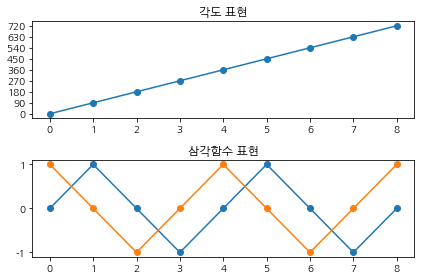

In [40]:
from sklearn.preprocessing import FunctionTransformer

def degree2sincos(X):
    x0 = np.sin(X * np.pi / 180)
    x1 = np.cos(X * np.pi / 180)
    X_new = np.hstack([x0, x1])
    return X_new

X2 = FunctionTransformer(degree2sincos).fit_transform(X)

plt.subplot(211)
plt.plot(X, marker="o")
plt.yticks(X.flatten())
plt.title("각도 표현")
plt.subplot(212)
plt.plot(X2, marker="o")
plt.title("삼각함수 표현")
plt.tight_layout()
plt.show()